In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../')
import evaluation
reload(evaluation)
from evaluation import get_anomaly_metrics

# Sample generation

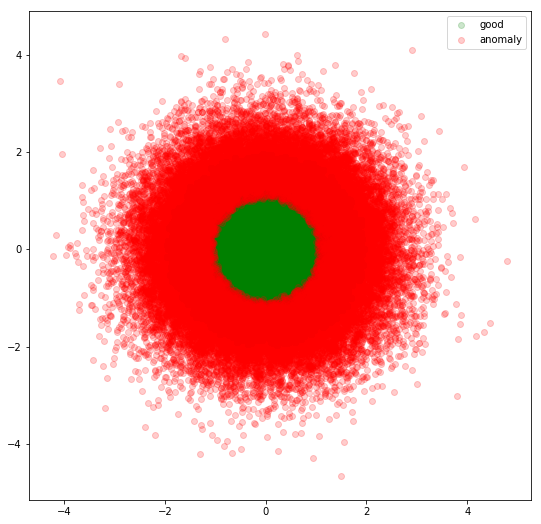

In [2]:
X_data = np.random.normal(size=(102400, 2))
r = np.sqrt(X_data[:, 0] ** 2 + X_data[:, 1] ** 2)
labels = 1 - np.random.binomial(1, p=1 - np.minimum(np.maximum(r - 1, 0), 1))

plt.figure(figsize=(9, 9))
plt.scatter(X_data[labels == 0, 0], X_data[labels == 0, 1], color='green', alpha=0.2, label='good')
plt.scatter(X_data[labels == 1, 0], X_data[labels == 1, 1], color='red', alpha=0.2, label='anomaly')
plt.legend()
plt.show()

# Utils

In [3]:
def plot_decision_boundary(predict_fn, title=None, alpha=0.005):
    x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
    y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    fig, ax = plt.subplots()

    Z = predict_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X_data[:, 0], X_data[:, 1], c=labels, s=20, edgecolor='k', alpha=alpha)
    if not title is None: ax.set_title(title)

    plt.show()

# Train-test split

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, train_size=0.5, test_size=0.5)

In [5]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [6]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [7]:
X_good.shape, X_bad.shape, X_train.shape, X_data.shape

((33781, 2), (17419, 2), (51200, 2), (102400, 2))

# One plus e NN

In [13]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DenseLayer
from layers import WeightNormLayer
from lasagne.nonlinearities import softmax
from lasagne.objectives import categorical_crossentropy

input_size = X_good.shape[1] # features cnt

input_var = T.matrix('input', dtype='float32')
weights_var = T.vector('weights', dtype='float32')
target_var = T.matrix('target', dtype='float32')
lr_var = T.scalar('learning rate')

network = InputLayer(shape=(None, input_size), input_var=input_var)
network = DenseLayer(network, 50)
network = WeightNormLayer(network)
network = DenseLayer(network, 2, nonlinearity=softmax)
output = lasagne.layers.get_output(network)

loss = (weights_var * categorical_crossentropy(output, target_var)).mean()
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.rmsprop(loss, params, learning_rate=lr_var)

train_fn = theano.function([input_var, weights_var, target_var, lr_var], [output, loss], updates=updates, allow_input_downcast=True)
predict_fn = theano.function([input_var], [output], allow_input_downcast=True)

In [14]:
X_min, X_max = np.min(X_data, axis=0), np.max(X_data, axis=0)

def random_sampling(size, features_range=[X_min, X_max]):
    return np.array([features_range[0][i] * np.ones(size) + np.random.rand(size) * (features_range[1][i] - features_range[0][i]) for i in range(len(features_range[0]))]).transpose()

In [15]:
import sys
sys.path.append('../')
from hmc import *

In [16]:
# from sklearn.metrics import *
from evaluation import get_anomaly_metrics
from keras.utils import to_categorical

lr = 5e-4
epoches = 5000
batch_size = 10000
sampler_batch_size = 10000
sampler_epoch_rate = 1
fraction = 10
alpha = 1e-3

true_bad_size = int(alpha * fraction * (1-y_train).sum())
fake_bad_size = int((1.0 - alpha) * fraction * (1-y_train).sum())
good_size = X_good.shape[0]

X_bad_true = X_train[y_train == 1][np.random.choice(np.arange(int(y_train.sum())), size=true_bad_size), :]
X_bad_fake = random_sampling(sampler_batch_size)


target = np.concatenate([np.zeros(good_size), np.ones(true_bad_size + fake_bad_size)])
good_weights = np.ones(X_good.shape[0])
true_bad_weights = alpha * np.ones(true_bad_size)
fake_bad_weights = (1 - alpha) * np.ones(fake_bad_size)

position = theano.shared(X_bad_fake)

def P(x):
    preds = x
    for layer in lasagne.layers.get_all_layers(network)[1:]: # pass x variable through all network layers except input one
        preds = layer.get_output_for(preds)
    preds = preds[:, 1]
    return 1 - T.exp(-preds / (1 - preds))

def get_P(x):
    preds = predict_fn(x)[0].squeeze()[:, 1]
    return 1 - np.exp(-preds / (1 - preds))

sampler = HMC_sampler.new_from_shared_positions(position, P,
                      initial_stepsize=1e-3, stepsize_max=0.5)

In [17]:
true_bad_size, fake_bad_size, good_size

(335, 335064, 33540)

In [24]:
for epoch in range(epoches):
    if epoch % 150 == 0 and epoch > 0:
        lr /= 3
    print('Epoch: %d' % epoch)
    
    [sampler.draw() for _ in range(sampler_epoch_rate)]
    
    X_bad_fake = np.concatenate([sampler.draw() for _ in range(int(round(fake_bad_size / sampler_batch_size)))][:fake_bad_size])
    X_mix = np.concatenate([X_good, X_bad_fake, X_bad_true])
    
    eps = 1e-4
    fake_bad_weights = 1./(eps + get_P(X_bad_fake))
#     fake_bad_weights /= max(fake_bad_weights)
    fake_bad_weights *= (1. - alpha)
    
    
    weights = np.concatenate([good_weights, fake_bad_weights, true_bad_weights])
    indices = np.arange(len(weights))
    np.random.shuffle(indices)
    for i in range(int(len(indices)/batch_size)):
        batch_idx = indices[range(batch_size*i,min(batch_size*(i+1), len(indices)))]
        _, loss_value = train_fn(X_mix[batch_idx], weights[batch_idx], to_categorical(list(target[batch_idx]) + [0,1])[:-2], lr)
    y_pred = predict_fn(X_test)[0].squeeze()[:, 1]
    metrics = get_anomaly_metrics(y_test, y_pred)
    print(metrics)
    
    print('Learning rate: ', lr)

Epoch: 0
{'Precision@0.9': 0.5551433601609658, 'Precision@0.8': 0.5551433601609658, 'PR_AUC': 0.9259427347954121, 'Precision@0.95': 0.5551433601609658, 'P@10': 1.0, 'Precision@0.99': 0.5551433601609658, 'ROC_AUC': 0.9565980804078951}
('Learning rate: ', 0.0005)
Epoch: 1
{'Precision@0.9': 0.5548642533936652, 'Precision@0.8': 0.5548642533936652, 'PR_AUC': 0.9252620326868828, 'Precision@0.95': 0.5548642533936652, 'P@10': 1.0, 'Precision@0.99': 0.5548642533936652, 'ROC_AUC': 0.9561887983083128}
('Learning rate: ', 0.0005)
Epoch: 2
{'Precision@0.9': 0.5454882456519724, 'Precision@0.8': 0.5454882456519724, 'PR_AUC': 0.9224385430954798, 'Precision@0.95': 0.5454882456519724, 'P@10': 1.0, 'Precision@0.99': 0.5454882456519724, 'ROC_AUC': 0.9547671221946035}
('Learning rate: ', 0.0005)
Epoch: 3
{'Precision@0.9': 0.5078595317725753, 'Precision@0.8': 0.5078595317725753, 'PR_AUC': 0.9168632365501671, 'Precision@0.95': 0.5078595317725753, 'P@10': 1.0, 'Precision@0.99': 0.5078595317725753, 'ROC_AUC': 

KeyboardInterrupt: 

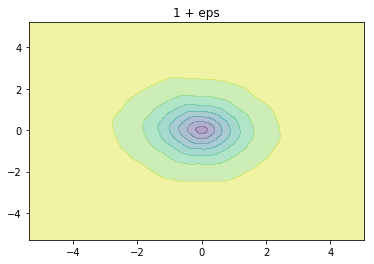

In [23]:
plot_decision_boundary(predict_fn=lambda x: predict_fn(x)[0][:, 1], title='1 + eps', alpha=0)

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

Score = y_pred

precision, recall, _ = precision_recall_curve(y_test, Score)
pr_auc = auc(recall, precision)

plt.figure()
plt.title('(1 + e) with Hamilton sampling')
plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

fpr, tpr, _ = roc_curve(y_test, Score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title('(1 + e) with Hamilton sampling')
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# OC methods

In [8]:
bad_cnt = int(1e-2 * X_good.shape[0])
X_mix = np.vstack([X_train[y_train == 0], X_train[y_train == 1][:bad_cnt]])
y_mix = np.concatenate([np.zeros_like(y_train[y_train == 0]), np.ones_like(y_train[y_train == 1][:bad_cnt])])

## XGBoost

In [22]:
import xgboost as xgb
import sys
sys.path.append('../../')
from evaluation import get_anomaly_metrics
clf = xgb.XGBClassifier(n_estimators=1000, learning_rate=1e-2)
clf.fit(X_mix, y_mix)
y_pred = clf.predict(X_test)
print(get_anomaly_metrics(y_test, y_pred))

{'Precision@0.9': 0.6598046875, 'Precision@0.8': 0.6598046875, 'PR_AUC': 0.5852612682797572, 'Precision@0.95': 0.6598046875, 'P@10': 1.0, 'Precision@0.99': 0.6598046875, 'ROC_AUC': 0.6858543460753701}


/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


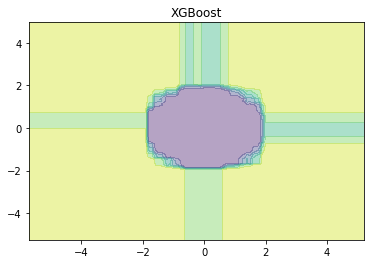

In [18]:
plot_decision_boundary(predict_fn=lambda x: clf.predict_proba(x)[:, 1], title='XGBoost', alpha=0)

# Isolation Forest and OC-SVM

Isolation Forest
{'Precision@0.9': 0.6598046875, 'Precision@0.8': 0.6598046875, 'PR_AUC': 0.7260951465598275, 'Precision@0.95': 0.6598046875, 'P@10': 0.8, 'Precision@0.99': 0.6598046875, 'ROC_AUC': 0.7368766676116463}


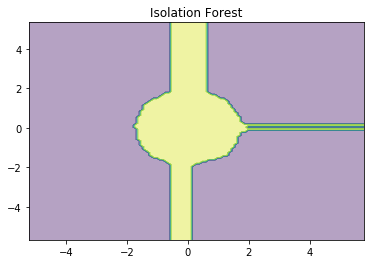

One-Class SVM
{'Precision@0.9': 0.6598046875, 'Precision@0.8': 0.6598046875, 'PR_AUC': 0.7226665251161442, 'Precision@0.95': 0.6598046875, 'P@10': 1.0, 'Precision@0.99': 0.6598046875, 'ROC_AUC': 0.8223073595440507}


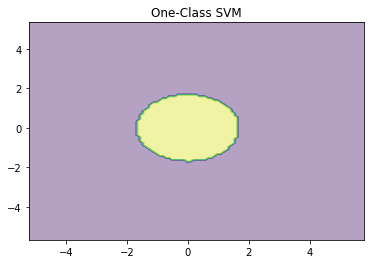

In [40]:
from sklearn import svm
from sklearn.ensemble import IsolationForest


classifiers_classic = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        contamination=0.01,
                                        random_state=10)}


for i, (clf_name, clf) in enumerate(classifiers_classic.items()):
        print(clf_name)
        clf.fit(X_good)
#         clf.fit(X_mix)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
        
        print(get_anomaly_metrics(y_test, y_pred))
#         plt.subplot(1,2,i+1)
        plot_decision_boundary(predict_fn=clf.predict, title=clf_name, alpha=0)

# Fraction curve

In [34]:
from sklearn.base import BaseEstimator
# from sklearn.metrics import *
from evaluation import get_anomaly_metrics
from keras.utils import to_categorical
import sys
sys.path.append('../')
from hmc import *
import theano.tensor as T
from lasagne.layers import InputLayer, DenseLayer
from layers import WeightNormLayer
from lasagne.nonlinearities import softmax
from lasagne.objectives import categorical_crossentropy
import lasagne

class OnePlusEps(BaseEstimator):
    def __init__(self, hidden_size=50, sampling_fraction=10, anomaly_label=1, lr=5e-4, 
                 epoches=10, batch_size=10000, sampler_batch_size=10000, sampler_epoch_rate=1):
        self._hidden_size = hidden_size
        self._sampling_fraction = sampling_fraction
        self._anomaly_label = anomaly_label
        self._lr = lr
        self._epoches = epoches
        self._batch_size = batch_size
        self._sampler_batch_size = sampler_batch_size
        self._sampler_epoch_rate = sampler_epoch_rate
    
    def fit(self, X, y):
        # Neural network
        input_size = X.shape[1] # features cnt
        
        X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)

        def random_sampling(size, features_range=[X_min, X_max]):
            return np.array([features_range[0][i] * np.ones(size) + np.random.rand(size) * (features_range[1][i] - features_range[0][i]) for i in range(len(features_range[0]))]).transpose()

        input_var = T.matrix('input', dtype='float32')
        weights_var = T.vector('weights', dtype='float32')
        target_var = T.matrix('target', dtype='float32')
        lr_var = T.scalar('learning rate')

        self._network = InputLayer(shape=(None, input_size), input_var=input_var)
        self._network = DenseLayer(self._network, self._hidden_size)
        self._network = WeightNormLayer(self._network)
        self._network = DenseLayer(self._network, 2, nonlinearity=softmax)
        self._output = lasagne.layers.get_output(self._network)

        loss = (weights_var * categorical_crossentropy(self._output, target_var)).mean()
        self._params = lasagne.layers.get_all_params(self._network, trainable=True)
        updates = lasagne.updates.rmsprop(loss, self._params, learning_rate=lr_var)

        train_fn = theano.function([input_var, weights_var, target_var, lr_var], [self._output, loss], updates=updates, allow_input_downcast=True)
        self._predict_fn = theano.function([input_var], [self._output], allow_input_downcast=True)
        
        
        X_good = X[y != self._anomaly_label]
        X_bad_true = X[y == self._anomaly_label]
        
        if self._anomaly_label != 1: y = 1 - y
        
        
        good_size = X_good.shape[0]
        true_bad_size = X_bad_true.shape[0]
        fake_bad_size = int(self._sampling_fraction * good_size)
        alpha = true_bad_size / (true_bad_size + fake_bad_size)
        
        X_bad_fake = random_sampling(self._sampler_batch_size)


        target = np.concatenate([np.zeros(good_size), np.ones(true_bad_size + fake_bad_size)])
        good_weights = np.ones(X_good.shape[0])
        
        true_bad_weights = alpha * np.ones(true_bad_size)
        fake_bad_weights = (1 - alpha) * np.ones(fake_bad_size)

        position = theano.shared(X_bad_fake)

        def P(x):
            preds = x
            for layer in lasagne.layers.get_all_layers(self._network)[1:]: # pass x variable through all network layers except input one
                preds = layer.get_output_for(preds)
            preds = preds[:, 1]
            return 1 - T.exp(-preds / (1 - preds))

        def get_P(x):
            preds = self._predict_fn(x)[0].squeeze()[:, 1]
            return 1 - np.exp(-preds / (1 - preds))

        self._sampler = HMC_sampler.new_from_shared_positions(position, P,
                              initial_stepsize=1e-3, stepsize_max=0.5)
        
        
        for epoch in range(self._epoches):
            # TODO: lr decay
            [self._sampler.draw() for _ in range(self._sampler_epoch_rate)]

            X_bad_fake = np.concatenate([self._sampler.draw() for _ in range(int(round(fake_bad_size / self._sampler_batch_size)))][:fake_bad_size])
            X_mix = np.concatenate([X_good, X_bad_fake, X_bad_true])

            eps = 1e-4
            fake_bad_weights = 1./(eps + get_P(X_bad_fake))
        #     fake_bad_weights /= max(fake_bad_weights)
            fake_bad_weights *= (1. - alpha)


            weights = np.concatenate([good_weights, fake_bad_weights, true_bad_weights])
            indices = np.arange(len(weights))
            np.random.shuffle(indices)
            for i in range(int(len(indices)/self._batch_size)):
                batch_idx = indices[range(self._batch_size*i,min(self._batch_size*(i+1), len(indices)))]
                _, loss_value = train_fn(X_mix[batch_idx], weights[batch_idx], to_categorical(list(target[batch_idx]) + [0,1])[:-2], self._lr)
                    
        
        
    def predict(self, X):
        return np.argmax(self._predict_fn(X)[0], axis=1)
    
    def predict_proba(self, X):
        return self._predict_fn(X)[0]
    

clf = OnePlusEps(epoches=20, lr=3e-3)
clf.fit(X_mix, y_mix)
y_pred = clf.predict(X_test)
print(get_anomaly_metrics(y_test, y_pred))

(337, 337810, 33781)
{'Precision@0.9': 0.6598046875, 'Precision@0.8': 0.6598046875, 'PR_AUC': 0.6598046875, 'Precision@0.95': 0.6598046875, 'P@10': 0.9, 'Precision@0.99': 0.6598046875, 'ROC_AUC': 0.5}


In [46]:
from sklearn import svm
from sklearn.ensemble import IsolationForest


fractions = [0, 0.1, 0.25, 0.5, 1]
points = len(fractions)
pr_aucs = {'Isolation Forest': [0.7260951465598275] * points, 'OC-SVM': [0.7226665251161442,] * points, 'XGBoost': [], 'OnePlusEpsNN': []}
roc_aucs = {'Isolation Forest': [0.7368766676116463] * points, 'OC-SVM': [0.8223073595440507] * points, 'XGBoost': [], 'OnePlusEpsNN': []}

from tqdm import tqdm

for fraction in tqdm(fractions):
    bad_cnt = int(fraction * X_good.shape[0])
    X_mix = np.vstack([X_train[y_train == 0], X_train[y_train == 1][:bad_cnt]])
    y_mix = np.concatenate([np.zeros_like(y_train[y_train == 0]), np.ones_like(y_train[y_train == 1][:bad_cnt])])
    shuffled_idx = np.arange(X_mix.shape[0])
    np.random.shuffle(shuffled_idx)
    X_mix, y_mix = X_mix[shuffled_idx], y_mix[shuffled_idx]
    
    for clf, clf_name in [(xgb.XGBClassifier(n_estimators=1000, learning_rate=1e-2), 'XGBoost'), (OnePlusEps(epoches=20, lr=3e-3), 'OnePlusEpsNN')]:
        clf.fit(X_mix, y_mix)
        y_pred = clf.predict(X_test)
        metrics = get_anomaly_metrics(y_test, y_pred)
        pr_aucs[clf_name].append(metrics['PR_AUC'])
        roc_aucs[clf_name].append(metrics['ROC_AUC'])
    


  0%|          | 0/5 [00:00<?, ?it/s]/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



(0, 337810, 33781)



 20%|██        | 1/5 [02:07<08:30, 127.63s/it]/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(3378, 337810, 33781)



 40%|████      | 2/5 [04:29<06:44, 134.98s/it]/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(8445, 337810, 33781)



 60%|██████    | 3/5 [07:07<04:45, 142.56s/it]/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(16890, 337810, 33781)



 80%|████████  | 4/5 [09:38<02:24, 144.62s/it]/home/aryzhikov/.conda/envs/lasagne2.7/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(17419, 337810, 33781)



100%|██████████| 5/5 [12:13<00:00, 146.72s/it]


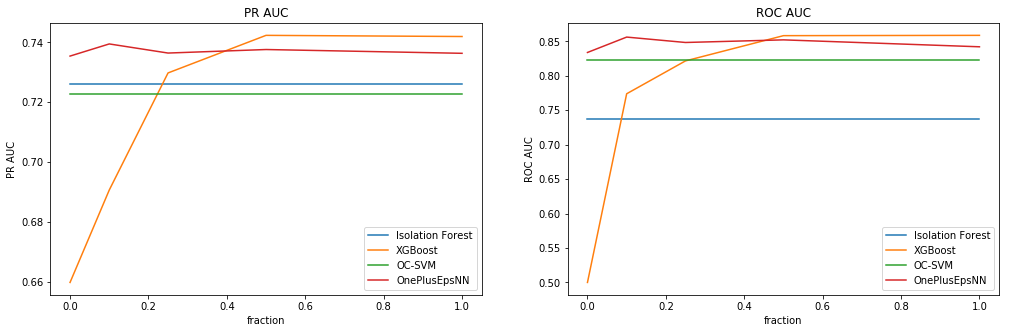

In [63]:
plt.figure(figsize=(17,5))

for clf_name in pr_aucs:
    pr_auc, roc_auc = pr_aucs[clf_name], roc_aucs[clf_name]
    plt.subplot(121)
    plt.title('PR AUC')
    plt.xlabel('fraction')
    plt.ylabel('PR AUC')
    plt.plot(fractions, pr_auc, label=clf_name)
    plt.legend()
    plt.subplot(122)
    plt.title('ROC AUC')
    plt.plot(fractions, roc_auc, label=clf_name)
    plt.xlabel('fraction')
    plt.ylabel('ROC AUC')
    plt.legend()
    